# Anime Super Resolution in PyTorch

---

[Github](https://github.com/eugenesiow/practical-ml/blob/master/notebooks/Remove_Image_Background_DeepLabV3.ipynb) | More Notebooks @ [eugenesiow/practical-ml](https://github.com/eugenesiow/practical-ml)

---

Notebook to do image super resolution on a single anime image automatically with pre-trained deep learning models in PyTorch.

[Image Super-Resolution](https://paperswithcode.com/task/image-super-resolution) techniques reconstruct a higher-resolution image or sequence from the observed lower-resolution images. In particular we do single-image super-resolution (SISR) which just use a single input image.

We utilise [yu45020's](https://github.com/yu45020) neat [PyTorch-based code](https://github.com/yu45020/Waifu2x) which re-implements the original [waifu2x](https://github.com/nagadomi/waifu2x) and includes other image super-resolution models for us to quickly compare results.

The notebook is structured as follows:
* Setting up the Environment
* Getting the data
* Using the Models (Running Inference)

# Setting up the Environment

#### Setup Runtime

The models run on `CPU` and there's no need to add a `GPU` hardware accelerator.

#### Setup Dependencies

We need to setup the `yu45020/Waifu2x` library and model checkpoints to run, so execute the command below to get the repository from Github.

In [1]:
!git clone -l -s https://github.com/yu45020/Waifu2x.git waifu2x
%cd waifu2x

Cloning into 'waifu2x'...
remote: Enumerating objects: 546, done.
remote: Total 546 (delta 0), reused 0 (delta 0), pack-reused 546
Receiving objects: 100% (546/546), 138.07 MiB | 25.76 MiB/s, done.
Resolving deltas: 100% (284/284), done.
/content/waifu2x


We need to extract the model checkpoints we intend to use with the following code.

In [2]:
%cd model_check_points/Upconv_7/
!7z e anime.7z
%cd ../CRAN_V2/
!unzip -qq -o CRAN_V2_02_28_2019.zip
%cd ../vgg_7/
!7z e art.7z
%cd ../../

/content/waifu2x/model_check_points/Upconv_7

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 19867323 bytes (19 MiB)

Extracting archive: anime.7z
--
Path = anime.7z
Type = 7z
Physical Size = 19867323
Headers Size = 279
Method = BZip2
Solid = +
Blocks = 1

  0%      5% 1 - anime/noise0_scale2.0x_model.json                                           11% 1 - anime/noise0_scale2.0x_model.json                                           17% 1 - anime/noise0_scale2.0x_model.json                                          

# Getting Data

#### Getting Sample Images

* An image of Nico Robin from anidb.

We'll save this image to our local storage and view a preview in our notebook.

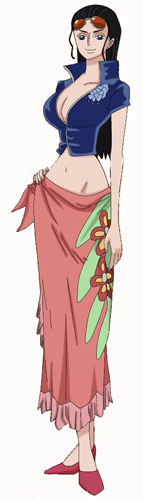

In [3]:
import cv2
from urllib.request import urlretrieve
from google.colab.patches import cv2_imshow

# save the image to our local storage
urlretrieve('https://cdn-us.anidb.net/images/main/80187.jpg', '/content/image.jpg')

# display the images in the notebook
cv2_imshow(cv2.imread('/content/image.jpg'))

# Using the Model (Running Inference)

Now we want to define a function to load and run the waifu2x pre-trained model checkpoints from the directory we have unzipped to. We are running 2x image super resolution.

Specifically we are running the following steps:

* Load the input image as `img` and create a baseline resized image called `img_t` with bicubic scaling to compare against our super res outputs. Add this to a tensor, `final`, which we will use to make the grid of images to compare at the end.
* Load (`.load_pre_train_weights()`) each of the model checkpoints specified in the `models` argument, which is a list of checkpoint `.json` files.
* Split our input image `img`, if its too large, into patches using the `.split_img_tensor()` method.
* Run the loaded model against each of the patches `model(i)`.
* Merge the output patches with `.merge_img_tensor(out)`.
* Concat the output super resolution upscaled image to the previous set of outputs (including the baseline `img_t`) using the `torch.cat()` function.
* Save the `final` tensor as an image grid of all the outputs using the TorchVision utility `save_image()` function. 

In [12]:
from utils.prepare_images import *
from Models import *
from torchvision.utils import save_image


def run_waifu2x(input_file, models, output_file):
  model = UpConv_7()
  img = Image.open(input_file).convert("RGB")
  img_resized = img.resize((img.size[0] * 2, img.size[1] * 2), Image.BICUBIC) 
  img_t = to_tensor(img_resized).unsqueeze(0) 
  # put the original image in the final tensor
  final = img_t
  for model_file in models:
    model.load_pre_train_weights(json_file=model_file)
    
    # overlapping split
    # if input image is too large, then split it into overlapped patches 
    # details can be found at [here](https://github.com/nagadomi/waifu2x/issues/238)
    img_splitter = ImageSplitter(seg_size=64, scale_factor=2, boarder_pad_size=3)
    img_patches = img_splitter.split_img_tensor(img, scale_method=None, img_pad=0)
    with torch.no_grad():
        out = [model(i) for i in img_patches]
    img_upscale = img_splitter.merge_img_tensor(out)

    # concat the upscaled image to the final tensor
    final = torch.cat([final, img_upscale])
  
  # save the image using the torchvision util that allows us to draw a grid of images from a tensor
  save_image(final, output_file, nrow=(1+len(models)))

Run the model on our input image `/content/image.jpg` to get an output grid of images for comparison, `/content/waifu2x_out.jpg`. We will run the `noise0`, `noise2` and `no noise` models against our image and compare with the baseline.

In [16]:
run_waifu2x('/content/image.jpg', ['model_check_points/Upconv_7/noise0_scale2.0x_model.json',
                                   'model_check_points/Upconv_7/noise2_scale2.0x_model.json',
                                   'model_check_points/Upconv_7/scale2.0x_model.json'], '/content/waifu2x_out.jpg')

Display the image grid output. We can see that the image is now 2x the original size. The leftmost image in the grid is our baseline that was scaled using `Image.BICUBIC` while the rest of the images are using `Waifu2x` models. I prefer the `noise2` model, the third image in the grid, most of the time. 

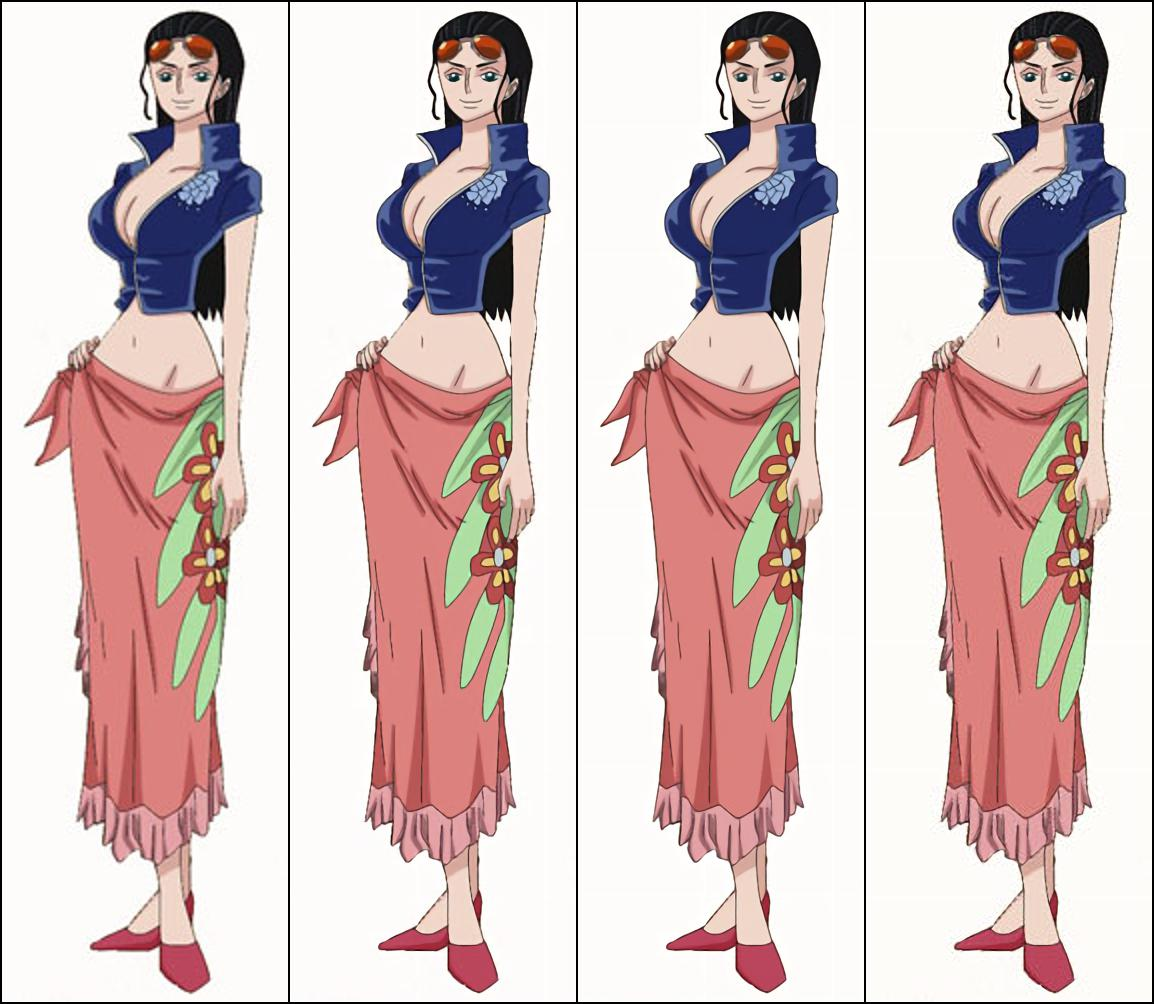

In [17]:
# display the output grid of images
cv2_imshow(cv2.imread('/content/waifu2x_out.jpg'))

Now we try the CARN V2 model. Similarly we define a function to run against our input image.

In [18]:
from utils.prepare_images import *
from Models import *
from torchvision.utils import save_image


def run_carn(input_file, models, output_file):
  model = CARN_V2(color_channels=3, mid_channels=64, conv=nn.Conv2d,
                        single_conv_size=3, single_conv_group=1,
                        scale=2, activation=nn.LeakyReLU(0.1),
                        SEBlock=True, repeat_blocks=3, atrous=(1, 1, 1))   
  model = network_to_half(model)
  img = Image.open(input_file).convert("RGB")
  img_resized = img.resize((img.size[0] * 2, img.size[1] * 2), Image.BICUBIC) 
  img_t = to_tensor(img_resized).unsqueeze(0) 
  # put the original image in the final tensor
  final = img_t
  for model_file in models:
    model.load_state_dict(torch.load(model_file, 'cpu'))
    model = model.float() 

    # overlapping split
    # if input image is too large, then split it into overlapped patches 
    # details can be found at [here](https://github.com/nagadomi/waifu2x/issues/238)
    img_splitter = ImageSplitter(seg_size=64, scale_factor=2, boarder_pad_size=3)
    img_patches = img_splitter.split_img_tensor(img, scale_method=None, img_pad=0)
    with torch.no_grad():
        out = [model(i) for i in img_patches]
    img_upscale = img_splitter.merge_img_tensor(out)

    # concat the upscaled image to the final tensor
    final = torch.cat([final, img_upscale])
  
  # save the image using the torchvision util that allows us to draw a grid of images from a tensor
  save_image(final, output_file, nrow=(1+len(models)))

We run the function against our input image and output the file to `CARN_V2_out.jpg` and display it using `cv2_imshow`. The left side image is the baseline while the right side image is the upscaled super-res image.

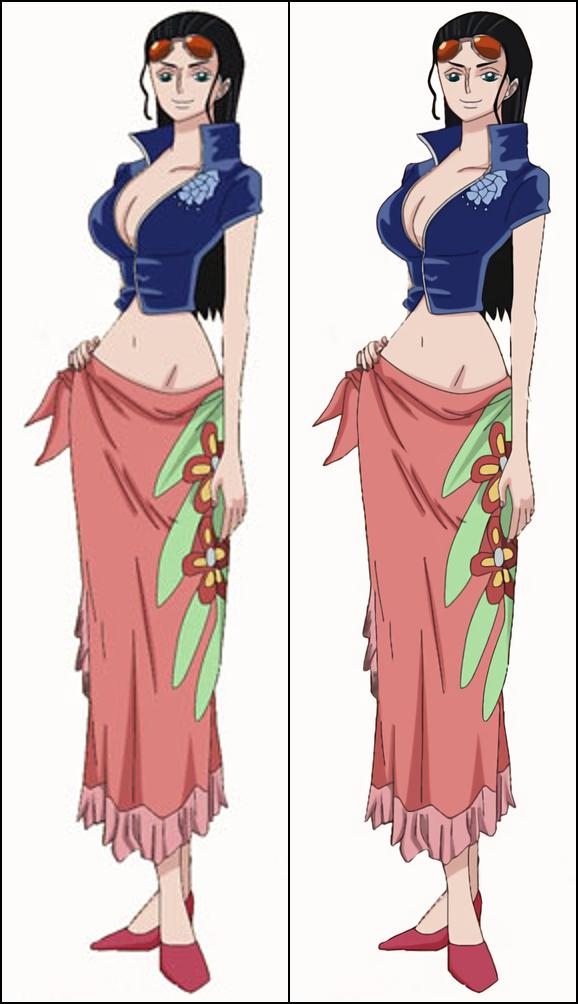

In [19]:
run_carn('/content/image.jpg', ['model_check_points/CRAN_V2/CARN_model_checkpoint.pt'], '/content/CARN_V2_out.jpg')
cv2_imshow(cv2.imread('/content/CARN_V2_out.jpg'))

If you want to save only your output image, change the output function to `save_image(img_upscale, '/content/CARN_V2_single.jpg')`. The code below does just this.

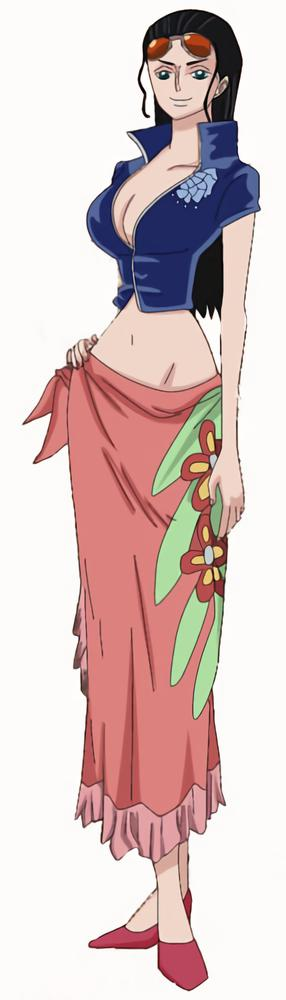

In [21]:
from utils.prepare_images import *
from Models import *
from torchvision.utils import save_image

model = CARN_V2(color_channels=3, mid_channels=64, conv=nn.Conv2d,
                      single_conv_size=3, single_conv_group=1,
                      scale=2, activation=nn.LeakyReLU(0.1),
                      SEBlock=True, repeat_blocks=3, atrous=(1, 1, 1))   
model = network_to_half(model)
model.load_state_dict(torch.load('model_check_points/CRAN_V2/CARN_model_checkpoint.pt', 'cpu'))
model = model.float() 
img = Image.open('/content/image.jpg').convert("RGB")
img_splitter = ImageSplitter(seg_size=64, scale_factor=2, boarder_pad_size=3)
img_patches = img_splitter.split_img_tensor(img, scale_method=None, img_pad=0)
with torch.no_grad():
    out = [model(i) for i in img_patches]
img_upscale = img_splitter.merge_img_tensor(out)
save_image(img_upscale, '/content/CARN_V2_single.jpg')
cv2_imshow(cv2.imread('/content/CARN_V2_single.jpg'))

We can connect to Google Drive with the following code. You can also click the `Files` icon on the left panel and click `Mount Drive` to mount your Google Drive.

The root of your Google Drive will be mounted to `/content/drive/My Drive/`. If you have problems mounting the drive, you can check out this [tutorial](https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166).

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

You can move the output files which are saved in the `/content/` directory to the root of your Google Drive.

In [ ]:
import shutil
shutil.move('/content/CARN_V2_single.jpg', '/content/drive/My Drive/CARN_V2_single.jpg')

More Notebooks @ [eugenesiow/practical-ml](https://github.com/eugenesiow/practical-ml) and do star or drop us some feedback on how to improve the notebooks on the [Github repo](https://github.com/eugenesiow/practical-ml/).